<a href="https://colab.research.google.com/github/gabriellaaileen/DTS-Project/blob/main/Text_Emotion_Recognition_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [112]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/Assignment/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/Assignment/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Assignment/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

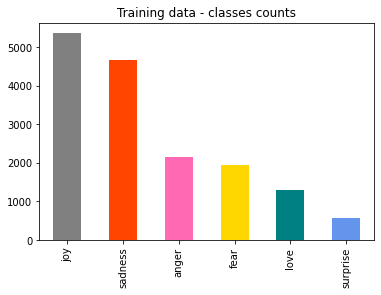

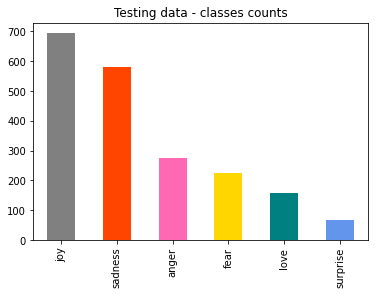

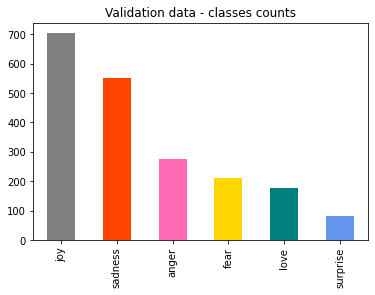

In [113]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

y_train.value_counts().plot(kind='bar', color=colors, title="Training data - classes counts")
plt.show()

y_test.value_counts().plot(kind='bar', color=colors, title="Testing data - classes counts")
plt.show()

y_val.value_counts().plot(kind='bar', color=colors, title="Validation data - classes counts")

In [114]:
# Encode labels
# Sudah disediakan beberapa variable, lengkapi variabel tersebut
le = LabelEncoder()
y_train = le.fit_transform(y_train) 
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [126]:
for i in range(len(list(le.classes_))):
  print(str(i)+" : "+list(le.classes_)[i])

0 : anger
1 : fear
2 : joy
3 : love
4 : sadness
5 : surprise


In [44]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [45]:
#Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/Assignment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [77]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)
#code here

# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
import tensorflow as tf

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabSize, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [101]:
#Callback
callback = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True
)

In [86]:
model_lstm.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=adam,metrics=['accuracy'])

In [87]:
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          258960    
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
 dense_10 (Dense)            (None, 6)                 42        
                                                                 
Total params: 271,936
Trainable params: 271,936
Non-trainable params: 0
_________________________________________________________________


In [98]:
# Fit model
history = model_lstm.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val),callbacks=callback)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


250/250 [==============================] - 6s 19ms/step - loss: 0.0190 - accuracy: 0.9932 - val_loss: 0.4446 - val_accuracy: 0.9195
Epoch 2/50
250/250 [==============================] - 5s 19ms/step - loss: 0.0284 - accuracy: 0.9910 - val_loss: 0.3876 - val_accuracy: 0.9260
Epoch 3/50
250/250 [==============================] - 5s 19ms/step - loss: 0.0187 - accuracy: 0.9935 - val_loss: 0.3936 - val_accuracy: 0.9265
Epoch 4/50
250/250 [==============================] - 5s 19ms/step - loss: 0.0084 - accuracy: 0.9962 - val_loss: 0.3818 - val_accuracy: 0.9255
Epoch 5/50
250/250 [==============================] - 5s 19ms/step - loss: 0.0079 - accuracy: 0.9969 - val_loss: 0.3834 - val_accuracy: 0.9250
Epoch 6/50
250/250 [==============================] - 5s 19ms/step - loss: 0.0058 - accuracy: 0.9969 - val_loss: 0.3991 - val_accuracy: 0.9230
Epoch 7/50
250/250 [==============================] - 5s 19ms/step - loss: 0.0049 - accuracy: 0.9974 - val_loss: 0.4157 - val_accuracy: 0.9230
Epoch 8/50

In [99]:
model_lstm.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 1s 11ms/step - loss: 0.3818 - accuracy: 0.9255


[0.3818376660346985, 0.9254999756813049]

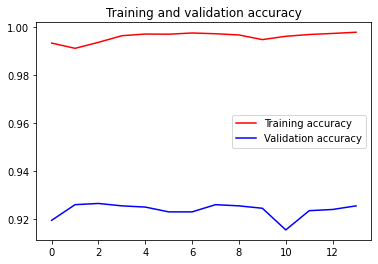

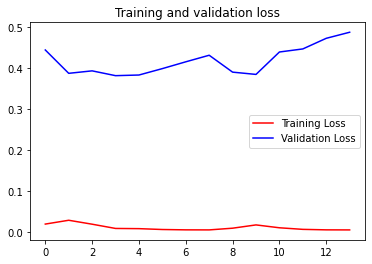

In [102]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [124]:
# Classify custom sample

sentences = [
            "i love studying machine learning with kak Akira" 
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model_lstm.predict(sentence), axis=-1))[0]
    proba =  np.max(model_lstm.predict(sentence))
    print(f"{result} : {proba}\n")

i love studying machine learning with kak Akira
joy : 0.8796312808990479



In [117]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model_lstm.save('Emotion Recognition.h5')